In [1]:
from c4 import Board, AgentRandom, AgentMinMaxMC, AgentMC
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import wandb

In [2]:
gameplays = []
with open("games3.txt") as inputfile:
    gameplays = inputfile.readlines()

gameplays = [list(s.strip('S\n')) for s in gameplays]
print(gameplays[0])

gameplays = [(xs[1:-1:], xs[-1]) for xs in gameplays]
print(gameplays[0])

['3', '3', '1', '2', '1', '1', '5', '6', '5', '5', '1', '0', '3', '5', '3', '3', '6', '5', '5', '1', '2', '0', '6', '6', '0', '2', '2', '0', '2', '3', '4', '0', '4', 'B']
(['3', '1', '2', '1', '1', '5', '6', '5', '5', '1', '0', '3', '5', '3', '3', '6', '5', '5', '1', '2', '0', '6', '6', '0', '2', '2', '0', '2', '3', '4', '0', '4'], 'B')


# Task 1
Let's assume that game state evaluated to 1.0 -> A wins, 0.0 -> B wins

In [3]:
def extractAB_from_board(board):
    DX = 7
    DY = 6
    A_board = [DX * [0] for y in range(DY)]
    B_board = [DX * [0] for y in range(DY)]
    for i in range(DY):
        for j in range(DX):
            if board[i][j] == 1:
                A_board[i][j] = 1
            if board[i][j] == -1:
                B_board[i][j] = 1

    return A_board, B_board

In [ ]:
boardslist = []
winnerslist = []

drawcount = 0

for game, winner in gameplays:
    current_board = Board()
    for move in game:
        current_board.apply_move(int(move))
        if winner == 'A':
            winnerslist.append(torch.Tensor([1.0]))
        elif winner == 'B':
            winnerslist.append(torch.Tensor([0.0]))
        else:
            drawcount += 1
            #winnerslist.append(torch.Tensor([0.0]))
            continue

        a_board, b_board = extractAB_from_board(current_board.board)
        #print(current_board.board)
        #print(a_board)
        #print(b_board)
        boardslist.append(torch.Tensor([current_board.board, a_board, b_board]))
        
    del current_board

data_boards = np.array(boardslist)
data_winners = np.array(winnerslist)

In [ ]:
print(drawcount / len(data_boards))
#print(data_boards)
#print(data_winners)

In [ ]:
class GameDataset(torch.utils.data.Dataset):
    def __init__(self, gamelist, winnerlist):
        self.gamelist = gamelist
        self.winnerlist = winnerlist
    def __len__(self):
        return len(self.gamelist)
    def __getitem__(self, idx):
        return self.gamelist[idx], self.winnerlist[idx]

shuffled_indexes = np.random.permutation(len(data_boards))

train_size = int(0.8 * len(data_boards))
print(train_size)
train_dataset = GameDataset(data_boards[shuffled_indexes[ : train_size ]], data_winners[shuffled_indexes[ : train_size ]])
test_dataset = GameDataset(data_boards[shuffled_indexes[ train_size : ]], data_winners[shuffled_indexes[ train_size : ]])

print(f"train length: {len(train_dataset)}, test length: {len(test_dataset)}")

batch_size = 32

game_dataloaders = {
    "train": torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=4, shuffle=True
    ),
}

In [ ]:
def plot_history(history):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.legend()

def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)            
            predictions = outputs.round()
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples

def compute_loss(model, data_loader, cuda=True):
    model.eval()
    sum_loss = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)            
            sum_loss += model.loss(outputs, y).sum()
            num_examples += x.size(0)
    return sum_loss / num_examples


def train(
    model, data_loaders, learning_rate, momentum, epochs=1, log_every=100, device="cuda", optimizer="SGD", wandblogging=False
):
    model.to(device)

    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    elif optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), 0.00001)
        
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    best_params = None
    best_valid_err = np.inf
    best_loss = np.inf
    iter_ = 0
    tstart = time.time()

    try:
        for epoch in range(epochs):
            model.train()
    
            losssum = 0.0
            epochiter = 0
            
            for x, y in data_loaders["train"]:         
                x = x.to(device)
                y = y.to(device)
    
                #print(f"x shape:{x.shape}")
                
                pred = model(x)
                loss = model.loss(pred, y)
    
                #for average loss
                losssum += loss.sum()
                epochiter += 1
    
                #print(f"loss: {loss}, losssum: {losssum}")
                #print(f"pred: {pred}")
                #print(f"predictions: {pred.round()}")
                predictions = pred.round()
                batch_err_rate = (predictions != y).sum().item() / pred.size(0)
    
                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)
                if wandblogging:
                    wandb.log({"train_error_rate" : batch_err_rate})

                print(f"loss:{loss}")
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
    
                iter_ += 1
                if log_every != -1 and iter_ % log_every == 0:
                    num_iter = iter_
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()
    
            avg_loss = losssum / epochiter
            valid_loss = compute_loss(model, data_loaders["test"], device)
            valid_err_rate = compute_error_rate(model, data_loaders["test"], device)
            
            history["val_errs"].append((iter_, valid_err_rate))
            if wandblogging:
                wandb.log({"valid_error_rate" : valid_err_rate})
    
            #if valid_err_rate < best_valid_err:
                #best_valid_err = valid_err_rate
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_epoch = epoch
                best_params = [p.detach().cpu() for p in model.parameters()]
                
            #clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | average loss: {2: .2f} | doing {3: >3} epochs".format(
                epoch, valid_err_rate * 100.0, avg_loss, epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param

    plot_history(history)
    return history

In [ ]:
class ModelConv(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ModelConv, self).__init__()
        mydropout = args[0]
        self.layers = nn.Sequential(nn.Conv2d(3, 64, 4, stride=1, padding=3),
                                    nn.ReLU(),
                                    #nn.MaxPool2d(2,1),
                                    nn.Dropout2d(mydropout),
                                    nn.Conv2d(64, 128, 3, stride=1, padding=2),
                                    nn.ReLU(),
                                    nn.Dropout2d(mydropout),
                                    #nn.MaxPool2d(2,1),
                                    nn.Conv2d(128, 128, 3, stride=1, padding=2),
                                    nn.ReLU(),
                                    nn.Dropout2d(mydropout),
                                    nn.Conv2d(128, 1, 1, stride=1),
                                    nn.ReLU(),
                                    nn.Dropout2d(mydropout),
                                    nn.Flatten(),
                                    nn.Linear(182, 64),
                                    nn.ReLU(),
                                    nn.Dropout(mydropout),
                                    nn.Linear(64, 1),
                                    nn.Sigmoid()
                                    )
        #self.lossfunc = nn.BCEWithLogitsLoss()
        self.lossfunc = nn.BCELoss()

    def forward(self, X):
        X = X.view(X.size(0), 3, 6, 7)
        return self.layers.forward(X)

    #def loss(self, Out, Targets):
        #return F.binary_cross_entropy(Out, Targets)
    
    def loss(self, Out, Targets):
        return self.lossfunc(Out, Targets)

modelConv = ModelConv(0.5)

In [ ]:
with torch.no_grad():
    # Initialize parameters
    for name, p in modelConv.named_parameters():
        if "weight" in name:
            #nn.init.xavier_normal_(p)
            nn.init.xavier_uniform_(p)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)
            
t_start = time.time()
train(modelConv, game_dataloaders, 0.0001, 0.99, epochs=20, log_every=10000)
print(f"training took {time.time() - t_start:.0f}s.")

Agent definition:

In [10]:
from importlib import reload
#from c4 import Board, AgentRandom, AgentMinMaxMC, AgentMC

#reload(c4)

In [41]:
def game(agent_a, agent_b):
    b = Board()
    agents = [agent_a, agent_b]
    moves = []
    
    who = 0
    
    while not b.end():
        m = agents[who].best_move(b)

        #print("before move")
        #b.printchars()
        
        b.apply_move(m) 

        #print("after move:")
        #b.printchars()
        
        who = 1-who
    
    #b.printchars() 
    print (b.result)
    #print ("X" * 20 + "\nEND OF GAME\n")
    print ()
    
    return b.result
    
def duel(agent_a, agent_b, N):
    score = {1:0, -1:0, 0:0}
    
    for i in range(N):
        r1 = game(agent_a, agent_b)
        score[r1] += 1
        r2 = game(agent_b, agent_a)
        score[-r2] += 1
    
    s = sum(score.values())

    print(score)
    
    for k in score:
        score[k] /= s    
    print (f'{agent_a.name}: {score[+1]}, {agent_b.name}: {score[-1]}, Draw: {score[0]}')     

In [42]:
class AgentCNN:
    def __init__(self, model):
        self.model = model
        self.model.to("cuda")
        self.name = 'AgentCNN'
        
    def best_move(self, b):
        boardresults = []
        
        bestresultmax = -2.0
        bestmovemax = 0
        bestresultmin = 2.0
        bestmovemin = 0
        
        #print(b.moves())
        print(f"my bot makes turn of player: {b.who}")

        with torch.no_grad():
            for m in b.moves():
                b.apply_move(m)
    
                a_board, b_board = extractAB_from_board(b.board)
                netinput = torch.Tensor([[b.board, a_board, b_board]])
                netinput = netinput.to("cuda")
    
                res = self.model(netinput).item()
                boardresults.append((m,res))
                if res > bestresultmax:
                    bestresultmax = res
                    bestmovemax = m
                if res < bestresultmin:
                    bestresultmin = res
                    bestmovemin = m
                
                b.undo_move(m)

        #b.printchars()
        #print(boardresults)
        #if b.who == 1:
        #    print(f"selected move: {bestmovemax}")
        #else:
        #    print(f"selected move: {bestmovemin}")

        if b.who == 1:
            return bestmovemax
        else:
            return bestmovemin

myAgent = AgentCNN(modelConv)

In [43]:
A = myAgent
B = AgentRandom()
#B = AgentMC(10)

duel(A, B, 500)

my bot makes turn of player: 1
my bot makes turn of player: 1
my bot makes turn of player: 1
my bot makes turn of player: 1
my bot makes turn of player: 1
1

my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
-1

my bot makes turn of player: 1
my bot makes turn of player: 1
my bot makes turn of player: 1
my bot makes turn of player: 1
1

my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
my bot makes turn of player: -1
-1

my bot makes turn of player: 1
my bot makes turn of player: 1
my bot makes turn of player: 1
my bot

# Task 2

In [6]:
def check_for_patterns(xs, pattern):
    lenxs = len(xs)
    lenpat = len(pattern)
    
    reslist = []
    #print(f"checking list {xs} for pattern {pattern}")
    if lenpat > lenxs:
        return 0

    res = 0
    for start in range(0, lenxs - lenpat):
        #print(f"{xs[start:lenpat+start]}")
        if xs[start:lenpat+start] == pattern:
            res += 1

    #print(f"result: {res}")
        
    return res

def get_rcd(board):
    DX, DY = 7, 6 
    rows, columns, diagonals = [], [], []
    
    npboard = np.array(board.board)
    npboardflipped = np.fliplr( np.array(board.board) )

    for col in range(DX):
        columns.append(list(npboard[:,col]))
        
    for row in range(DY):
        rows.append(list(npboard[row,:]))
    
    for offset_ in range(-6, 6):
        diagonals.append(list(npboard.diagonal(offset=offset_)))
        diagonals.append(list(npboardflipped.diagonal(offset=offset_)))

    #board.printchars()
    #print(f"rows:{rows},\n columns:{columns},\n diagonals:{diagonals}")
    
    return rows, columns, diagonals


def extract_features(board):
    rows, columns, diagonals = get_rcd(board)
    features = [board.who, board.move_number]
    
    # number of available moves
    features.append(len(board.moves()))

    # analysis of previous moves
    lm = np.array( board.last_moves )
    amoves = lm[0::2]
    bmoves = lm[1::2]
    # moves average
    features.append(np.average(amoves))
    if len(bmoves) > 0:
        features.append(np.average(bmoves))
    else:
        features.append(0)
    if len(amoves) > 0:
        features.append(np.average(amoves[-1]))
    else:
        features.append(0)
    if len(bmoves) > 0:
        features.append(np.average(bmoves[-1]))
    else:
        features.append(0)

    # analysis of board
    for coin in [-1, 1]:
        patterns = []
         # number of 2, 3 coins in a row with 2 free spaces, 1 free space around
        for count in [2, 3]:
            patterns += [[0] + ([coin] * count), ([coin] * count) + [0],
                [0] + ([coin] * count) + [0] ]
        patterns.append( [ coin, 0, coin ] )
        patterns.append( [ 0, coin, 0, coin, 0 ] )
        patterns.append( [ coin, coin, 0, coin ] )
        patterns.append( [ coin, 0, coin, coin ] )
        patterns.append( [ coin, coin, 0, coin, 0 ] )
        patterns.append( [ 0, coin, 0, coin, coin ] )
        patterns.append( [ coin, 0, coin, 0 ] )
        patterns.append( [ 0, coin, 0, coin ] )
        patterns.append( [ coin, coin ] )
        patterns.append( [ coin, coin, coin ] )
        patterns.append( [ coin, coin, coin, coin ] )

        for pattern in patterns:
            count_pattern = 0
            for r in rows:
                count_pattern += check_for_patterns(r, pattern)
            for c in columns:
                count_pattern += check_for_patterns(c, pattern)
            for d in diagonals:
                count_pattern += check_for_patterns(d, pattern)

            features.append(count_pattern)

    #board.printchars()
    #print(f"features: {features}")
    
    return features

In [7]:
featureslist = []
winnerslist = []

counter = 0
for game, winner in gameplays:
    current_board = Board()
    for move in game:
        current_board.apply_move(int(move))
        if winner == 'A':
            winnerslist.append(torch.Tensor([1.0]))
        elif winner == 'B':
            winnerslist.append(torch.Tensor([0.0]))
        else:
            continue

        featureslist.append(torch.Tensor(extract_features(current_board)))
        
    counter += 1
    if counter % 100 == 0:
        print(f"{100.0 * counter / len(gameplays)}%")
        
    del current_board

data_features = np.array(featureslist)
data_winners = np.array(winnerslist)

0.5%
1.0%
1.5%
2.0%
2.5%
3.0%
3.5%
4.0%
4.5%
5.0%
5.5%
6.0%
6.5%
7.0%
7.5%
8.0%
8.5%
9.0%
9.5%
10.0%
10.5%
11.0%
11.5%
12.0%
12.5%
13.0%
13.5%
14.0%
14.5%
15.0%
15.5%
16.0%
16.5%
17.0%
17.5%
18.0%
18.5%
19.0%
19.5%
20.0%
20.5%
21.0%
21.5%
22.0%
22.5%
23.0%
23.5%
24.0%
24.5%
25.0%
25.5%
26.0%
26.5%
27.0%
27.5%
28.0%
28.5%
29.0%
29.5%
30.0%
30.5%
31.0%
31.5%
32.0%
32.5%
33.0%
33.5%
34.0%
34.5%
35.0%
35.5%
36.0%
36.5%
37.0%
37.5%
38.0%
38.5%
39.0%
39.5%
40.0%
40.5%
41.0%
41.5%
42.0%
42.5%
43.0%
43.5%
44.0%
44.5%
45.0%
45.5%
46.0%
46.5%
47.0%
47.5%
48.0%
48.5%
49.0%
49.5%
50.0%
50.5%
51.0%
51.5%
52.0%
52.5%
53.0%
53.5%
54.0%
54.5%
55.0%
55.5%
56.0%
56.5%
57.0%
57.5%
58.0%
58.5%
59.0%
59.5%
60.0%
60.5%
61.0%
61.5%
62.0%
62.5%
63.0%
63.5%
64.0%
64.5%
65.0%
65.5%
66.0%
66.5%
67.0%
67.5%
68.0%
68.5%
69.0%
69.5%
70.0%
70.5%
71.0%
71.5%
72.0%
72.5%
73.0%
73.5%
74.0%
74.5%
75.0%
75.5%
76.0%
76.5%
77.0%
77.5%
78.0%
78.5%
79.0%
79.5%
80.0%
80.5%
81.0%
81.5%
82.0%
82.5%
83.0%
83.5%
84.0%
84.5%
85.0%

In [8]:
class GameDataset(torch.utils.data.Dataset):
    def __init__(self, gamelist, winnerlist):
        self.gamelist = gamelist
        self.winnerlist = winnerlist
    def __len__(self):
        return len(self.gamelist)
    def __getitem__(self, idx):
        return self.gamelist[idx], self.winnerlist[idx]

shuffled_indexes = np.random.permutation(len(data_features))

train_size = int(0.8 * len(data_features))
print(train_size)
train_dataset = GameDataset(data_features[shuffled_indexes[ : train_size ]], data_winners[shuffled_indexes[ : train_size ]])
test_dataset = GameDataset(data_features[shuffled_indexes[ train_size : ]], data_winners[shuffled_indexes[ train_size : ]])

print(f"train length: {len(train_dataset)}, test length: {len(test_dataset)}")

batch_size = 32

game_dataloaders = {
    "train": torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=4, shuffle=True
    ),
}

print(data_features.shape)

457585
train length: 457585, test length: 114397
(571982, 41)


In [57]:
class ModelConv2(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ModelConv2, self).__init__()
        mydropout = args[0]
        self.layers = nn.Sequential(
                                    nn.Linear(41, 128),
                                    nn.Tanh(),
                                    nn.Dropout(mydropout),
                                    nn.Linear(128, 128),
                                    nn.Tanh(),
                                    nn.Dropout(mydropout),
                                    nn.Linear(128, 32),
                                    nn.Tanh(),
                                    nn.Dropout(mydropout),
                                    nn.Linear(32, 1),
                                    nn.Sigmoid()
                                    )
        #self.lossfunc = nn.BCEWithLogitsLoss()
        self.lossfunc = nn.BCELoss()

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
    
    def loss(self, Out, Targets):
        return self.lossfunc(Out, Targets)

modelConv2 = ModelConv2(0.8)

Minibatch  10000  | loss  1.08 | err rate 56.25%, steps/s 785.65
--------------------------------------------------------------------------------
After epoch  0 | valid err rate: 48.69% | average loss:  1.29 | doing  20 epochs
--------------------------------------------------------------------------------
Minibatch  20000  | loss  1.03 | err rate 40.62%, steps/s 1202.81
--------------------------------------------------------------------------------
After epoch  1 | valid err rate: 46.90% | average loss:  1.10 | doing  20 epochs
--------------------------------------------------------------------------------
Minibatch  30000  | loss  1.21 | err rate 56.25%, steps/s 1735.06
Minibatch  40000  | loss  1.00 | err rate 56.25%, steps/s 3084.70
--------------------------------------------------------------------------------
After epoch  2 | valid err rate: 46.19% | average loss:  0.95 | doing  20 epochs
--------------------------------------------------------------------------------
Minibatc

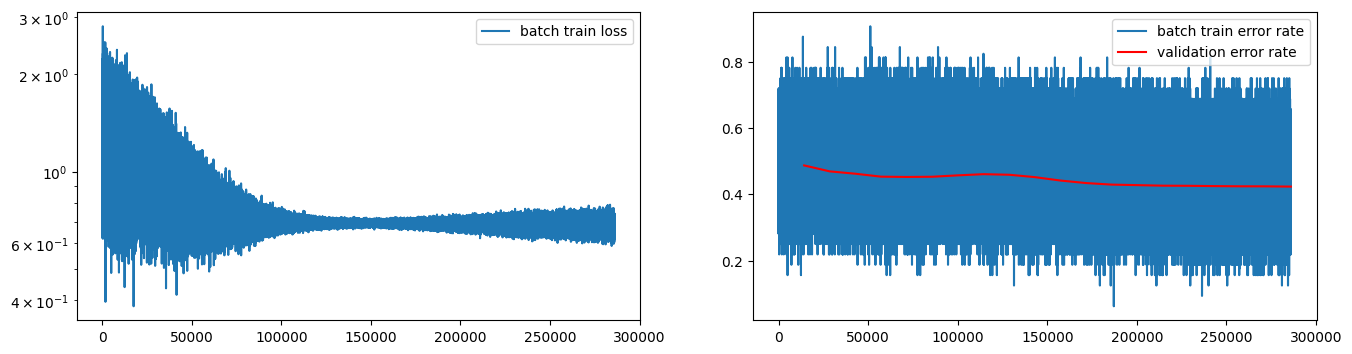

In [62]:
with torch.no_grad():
    # Initialize parameters
    for name, p in modelConv2.named_parameters():
        if "weight" in name:
            nn.init.xavier_normal_(p)
            #nn.init.xavier_uniform_(p)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)
            
t_start = time.time()
train(modelConv2, game_dataloaders, 0.000000001, 0.99, epochs=20, optimizer="Adam", log_every=10000)
print(f"training took {time.time() - t_start:.0f}s.")

In [63]:
def game(agent_a, agent_b):
    b = Board()
    agents = [agent_a, agent_b]
    moves = []
    
    who = 0
    
    while not b.end():
        m = agents[who].best_move(b)

        #print("before move")
        #b.printchars()
        
        b.apply_move(m) 

        #print("after move:")
        #b.printchars()
        
        who = 1-who
    
    #b.printchars() 
    print (b.result)
    #print ("X" * 20 + "\nEND OF GAME\n")
    print ()
    
    return b.result
    
def duel(agent_a, agent_b, N):
    score = {1:0, -1:0, 0:0}
    
    for i in range(N):
        r1 = game(agent_a, agent_b)
        score[r1] += 1
        r2 = game(agent_b, agent_a)
        score[-r2] += 1
    
    s = sum(score.values())

    print(score)
    
    for k in score:
        score[k] /= s    
    print (f'{agent_a.name}: {score[+1]}, {agent_b.name}: {score[-1]}, Draw: {score[0]}')   

In [64]:
class AgentCNNv2:
    def __init__(self, model):
        self.model = model
        self.model.to("cuda")
        self.name = 'AgentCNNv2'
        
    def best_move(self, b):
        boardresults = []
        
        bestresultmax = -2.0
        bestmovemax = 0
        bestresultmin = 2.0
        bestmovemin = 0
        
        #print(b.moves())
        #print(f"my bot makes turn of player: {b.who}")

        with torch.no_grad():
            for m in b.moves():
                b.apply_move(m)
    
                netinput = torch.Tensor([extract_features(b)])
                netinput = netinput.to("cuda")
    
                res = self.model(netinput).item()
                boardresults.append((m,res))
                if res > bestresultmax:
                    bestresultmax = res
                    bestmovemax = m
                if res < bestresultmin:
                    bestresultmin = res
                    bestmovemin = m
                
                b.undo_move(m)

        #b.printchars()
        #print(boardresults)
        #if b.who == 1:
        #    print(f"selected move: {bestmovemax}")
        #else:
        #    print(f"selected move: {bestmovemin}")

        if b.who == 1:
            return bestmovemax
        else:
            return bestmovemin

myAgent2 = AgentCNNv2(modelConv2)

In [65]:
A = myAgent2
B = AgentRandom()
#B = AgentMC(10)

duel(A, B, 500)

-1

1

-1

-1

1

1

1

-1

-1

1

-1

1

-1

-1

1

1

-1

1

1

1

-1

1

1

1

1

1

-1

-1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

-1

-1

0

-1

-1

-1

1

-1

1

1

-1

1

1

1

1

1

1

-1

1

-1

1

1

0

-1

1

-1

1

-1

1

1

1

-1

1

1

1

-1

1

-1

-1

1

1

1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

1

1

-1

-1

1

1

1

1

1

1

1

1

-1

-1

1

1

-1

1

-1

1

-1

1

-1

1

-1

-1

1

1

1

-1

1

1

1

1

1

1

1

-1

-1

1

-1

-1

-1

1

-1

1

1

-1

1

1

1

1

1

1

-1

1

-1

1

1

1

1

1

-1

1

1

1

1

1

1

1

-1

-1

-1

1

-1

1

1

1

1

-1

-1

-1

1

1

-1

-1

1

1

-1

-1

-1

-1

1

1

1

1

1

1

1

1

1

1

-1

1

1

-1

-1

-1

1

1

-1

1

1

1

-1

1

-1

1

-1

1

1

-1

-1

1

1

1

-1

-1

1

1

1

1

1

1

-1

1

1

1

-1

-1

-1

1

1

1

-1

1

-1

1

1

-1

-1

1

-1

1

1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

-1

1

1

1

1

-1

1

-1

1

-1

1

-1

1

1

1

1

1

1

1

1

1

-1

-1



In [16]:
A = myAgent2
#B = AgentRandom()
B = AgentMC(10)

duel(A, B, 500)

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1

-1

1


KeyboardInterrupt: 